<a href="https://colab.research.google.com/github/Fermu25/Cursos/blob/main/Tarea11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DBSCAN utiliza, por defecto, la distancia Euclidiana ($L_2$ norm). La distancia entre dos puntos $p = (x_1, y_1)$ y $q = (x_2, y_2)$ se calcula como:

$$d(p,q) = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$$

Si la variable $x$ tiene un rango mayor y $y$ tiene un rango menor o viceversa, una diferencia pequeña en $x$ contribuirá mucho más a la distancia total que una gran diferencia en $y$.

Aplicamos la estandarización Z-score utilizando StandardScaler de la biblioteca Scikit-Learn. Este proceso transforma cada característica $x$ en $z$ tal que:

$$z = \frac{x - \mu}{\sigma}$$

donde $\mu$ es la media de la muestra y $\sigma$ es la desviación estándar.
Tras esta transformación, todas las características tienen una media de 0 y una desviación estándar de 1.

Esto tiene dos efectos:

La distancia Euclidiana pondera todas las dimensiones equitativamente. La vecindad circular definida por $\varepsilon$ tiene sentido en todas las direcciones.

El valor de $\varepsilon$ se convierte en una medida de desviaciones estándar. Un $\varepsilon = 0.2$ significa que buscamos vecinos dentro de 0.2 desviaciones estándar.

Media: [ 3.19744231e-16 -3.10862447e-16]
Desviación : [1. 1.]


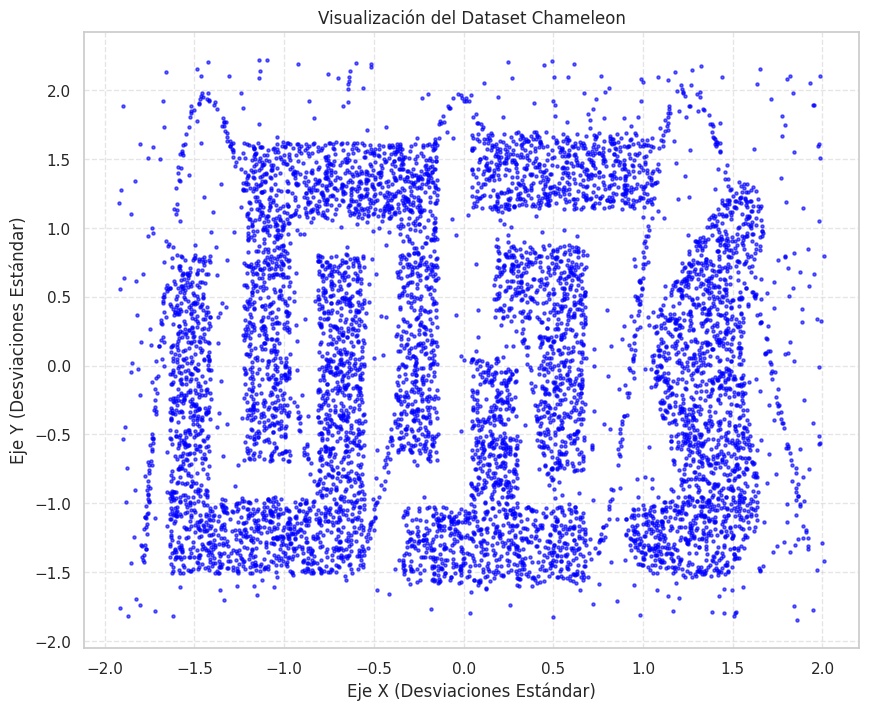

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Carga de datos
df = pd.read_csv('chameleon.csv', header=None)
# Asignar nombres de columnas
df.columns = ['x', 'y']

scaler = StandardScaler()

# Transformación de los datos. El resultado es un array de numpy
data_scaled = scaler.fit_transform(df)

# Convertimos el array de numpy de vuelta a DataFrame
df_scaled = pd.DataFrame(data_scaled, columns=["x", "y"])

# Verificación post-estandarización
print(f"Media: {np.mean(data_scaled, axis=0)}")
print(f"Desviación : {np.std(data_scaled, axis=0)}")

# Visualización
plt.figure(figsize=(10, 8))
plt.scatter(df_scaled["x"], df_scaled["y"], s=5, color="blue", alpha=0.6)# alpha=0.6 hace los puntos semitransparentes para ver mejor dónde hay mucha densidad
plt.title("Visualización del Dataset Chameleon")
plt.xlabel("Eje X (Desviaciones Estándar)")
plt.ylabel("Eje Y (Desviaciones Estándar)")
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Determinación de los parámetros óptimos ($\varepsilon$, $MinPts$) para DBSCAN.
A diferencia de K-Means, donde se puede iterar sobre $k$ y medir la inercia, DBSCAN requiere una comprensión de la densidad topológica antes de la ejecución. Para ello se hace uso de la "gráfica de codo" basada en las distancias a los $k$-vecinos más cercanos ($k$-distance graph).

El parámetro $MinPts$ define la granularidad del agrupamiento.
La literatura sugiere $MinPts \geq D + 1$, donde $D$ es la dimensión de los datos.Para datos 2D, esto implica $MinPts \geq 3$.




Datos cargados: (8000, 2) muestras, (8000, 2) dimensiones.


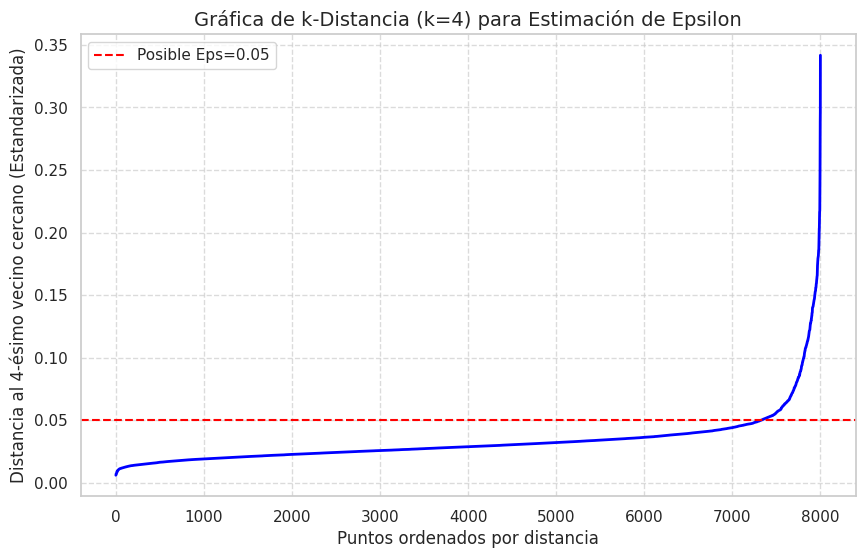

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import seaborn as sns

# Configuración de estilo para gráficos
sns.set(style="whitegrid")

#1. Cargar datos
data = pd.read_csv('chameleon.csv', header=None)
X = data.values
print(f"Datos cargados: {X.shape} muestras, {X.shape} dimensiones.")

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Selección de Epsilon mediante Gráfica de k-Distancia
# Definimos k = 4 para buscar el 4to vecino más cercano (suponiendo MinPts 5)
k = 4
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distancias, indices = nbrs.kneighbors(X_scaled)

# Tomamos la distancia critica del k-ésimo vecino (columna k-1)
k_dist = distancias[:, k-1]

# Ordenamos las distancias para la gráfica de codo
k_dist_sorted = np.sort(k_dist)

plt.figure(figsize=(10, 6))
plt.plot(range(len(X_scaled)), k_dist_sorted, color='blue', linewidth=2)
plt.title(f'Gráfica de k-Distancia (k={k}) para Estimación de Epsilon', fontsize=14)
plt.xlabel('Puntos ordenados por distancia', fontsize=12)
plt.ylabel(f'Distancia al {k}-ésimo vecino cercano (Estandarizada)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Identificación del codo
eps_visual = 0.05 #variar el numero para ver donde cruza aproximadamente 0.05prox
plt.axhline(y=eps_visual, color='red', linestyle='--', label=f'Posible Eps={eps_visual}')
plt.legend()
plt.show()

La "Meseta": La parte inicial de la curva, que es baja y plana, representa los puntos que están profundamente inmersos en clústeres densos.
El "Codo": El punto de máxima curvatura donde la gráfica comienza a ascender verticalmente. Este punto crítico indica el umbral de distancia donde los puntos dejan de estar en una densidad "clúster" y comienzan a ser ruido o puentes dispersos. El valor de $y$ (distancia) en este codo es el candidato óptimo para $\varepsilon$=0.05
La "Cola" Vertical: Representa los valores atípicos extremos.


--- Resultados del Clustering (MinPts=5, Eps=0.05) ---
Número de clústeres encontrados: 43
Puntos de ruido: 533 (6.66%)


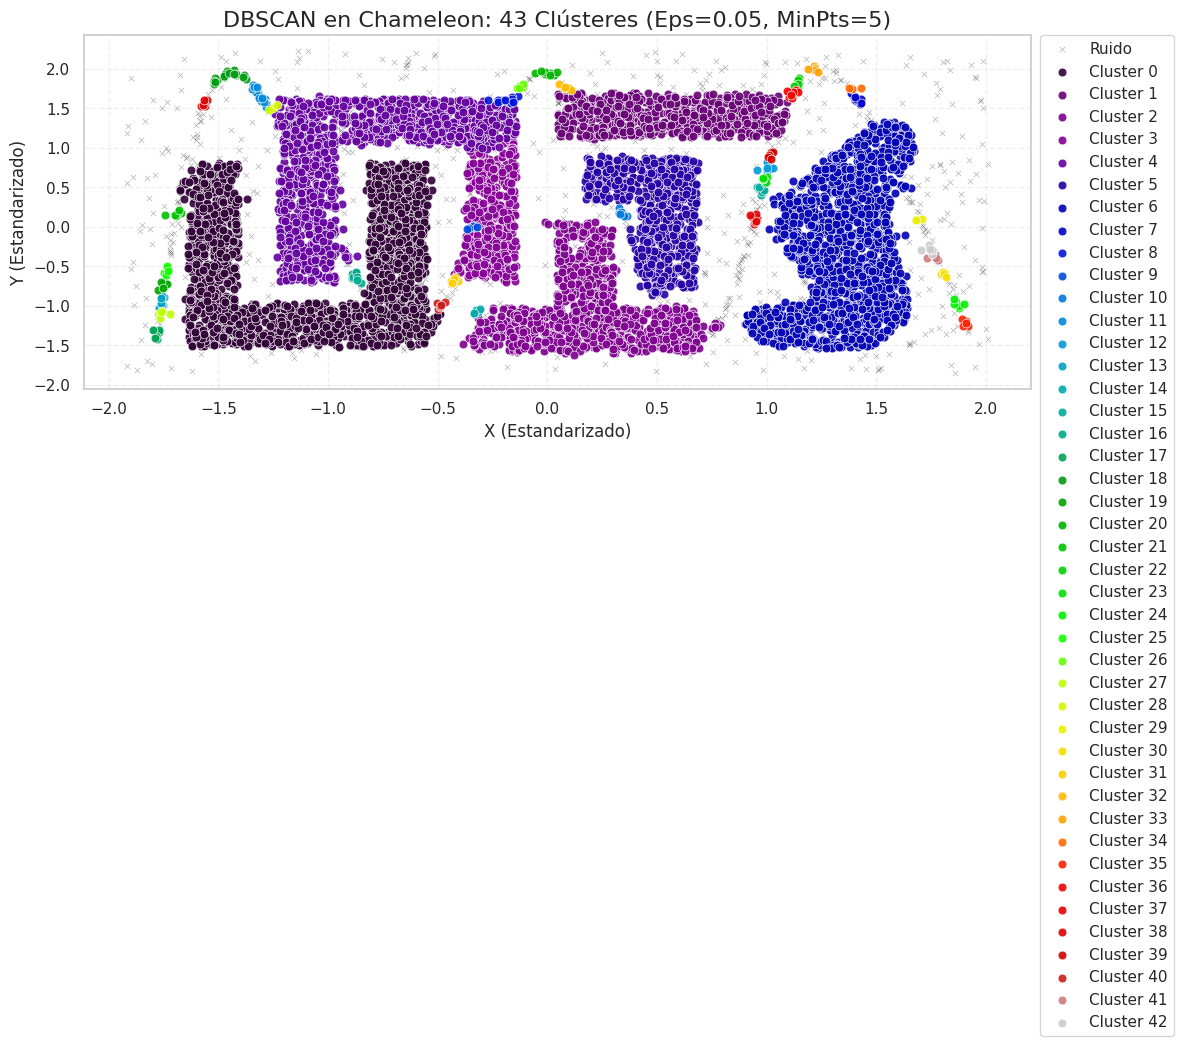

In [ ]:
# 3. Aplicación de DBSCAN
# Configuramos DBSCAN con el eps seleccionado y min_samples derivado de k
dbscan = DBSCAN(eps=eps_visual, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

# 4. Análisis y Visualización de Resultados
# Convertimos el array de etiquetas a un conjunto (set) para eliminar duplicados.
# Restamos 1 SÓLO si el conjunto contiene la etiqueta -1, ya que
# para DBSCAN el -1 es ruido/basura, no un clúster válido.
labels_unique = set(clusters)
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
# Contamos cuántas veces aparece exactamente el valor -1 en la lista de resultados.
# Estos son los puntos "huérfanos" que no cumplieron la condición de densidad.
n_noise = list(clusters).count(-1)
noise_percent = (n_noise / len(X_scaled)) * 100

print(f"\n--- Resultados del Clustering (MinPts=5, Eps={eps_visual}) ---")
print(f"Número de clústeres encontrados: {n_clusters}")
print(f"Puntos de ruido: {n_noise} ({noise_percent:.2f}%)")

# Visualización de los clústeres
plt.figure(figsize=(12, 8))
# Etiquetas ordenadas para asignar colores
unique_labels = sorted(list(set(clusters)))
cmap = plt.get_cmap("nipy_spectral")

# Iteramos sobre cada etiqueta encontrada
for i, k_label in enumerate(unique_labels):
# Máscara para seleccionar solo los puntos del clúster actual
    class_member_mask = (clusters == k_label)
    xy = X_scaled[class_member_mask]

    if k_label == -1:
        # ESTILO RUIDO
        col = [0, 0, 0, 1] # Negro puro
        alpha = 0.3        # Más transparente
        size = 15          # Ligeramente más grande para verse
        marker = 'x'       # 'x' para diferenciar geometría
        label_name = "Ruido"
        edge_color = None  # no lleva borde de relleno
    else:
        # ESTILO CLÚSTERES
        # Dividimos i entre el total para usar todo el espectro de colores (0.0 a 1.0)
        color_index = i / (len(unique_labels) - 1) if len(unique_labels) > 1 else 0.5
        col = cmap(color_index)

        alpha = 0.9        # Mayor opacidad para que resalten
        size = 40          # Tamaño más visible
        marker = 'o'       # Círculo
        label_name = f"Cluster {k_label}"
        edge_color = 'white' # Borde blanco para separar puntos visualmente

    plt.scatter(xy[:, 0], xy[:, 1],
                c=[col],            # Color debe ser una lista/array
                s=size,
                alpha=alpha,
                marker=marker,
                edgecolors=edge_color,
                linewidth=0.5,         # Grosor del borde blanco
                label=label_name)

plt.title(f'DBSCAN en Chameleon: {n_clusters} Clústeres (Eps={eps_visual}, MinPts=5)', fontsize=16)
plt.xlabel('X (Estandarizado)')
plt.ylabel('Y (Estandarizado)')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

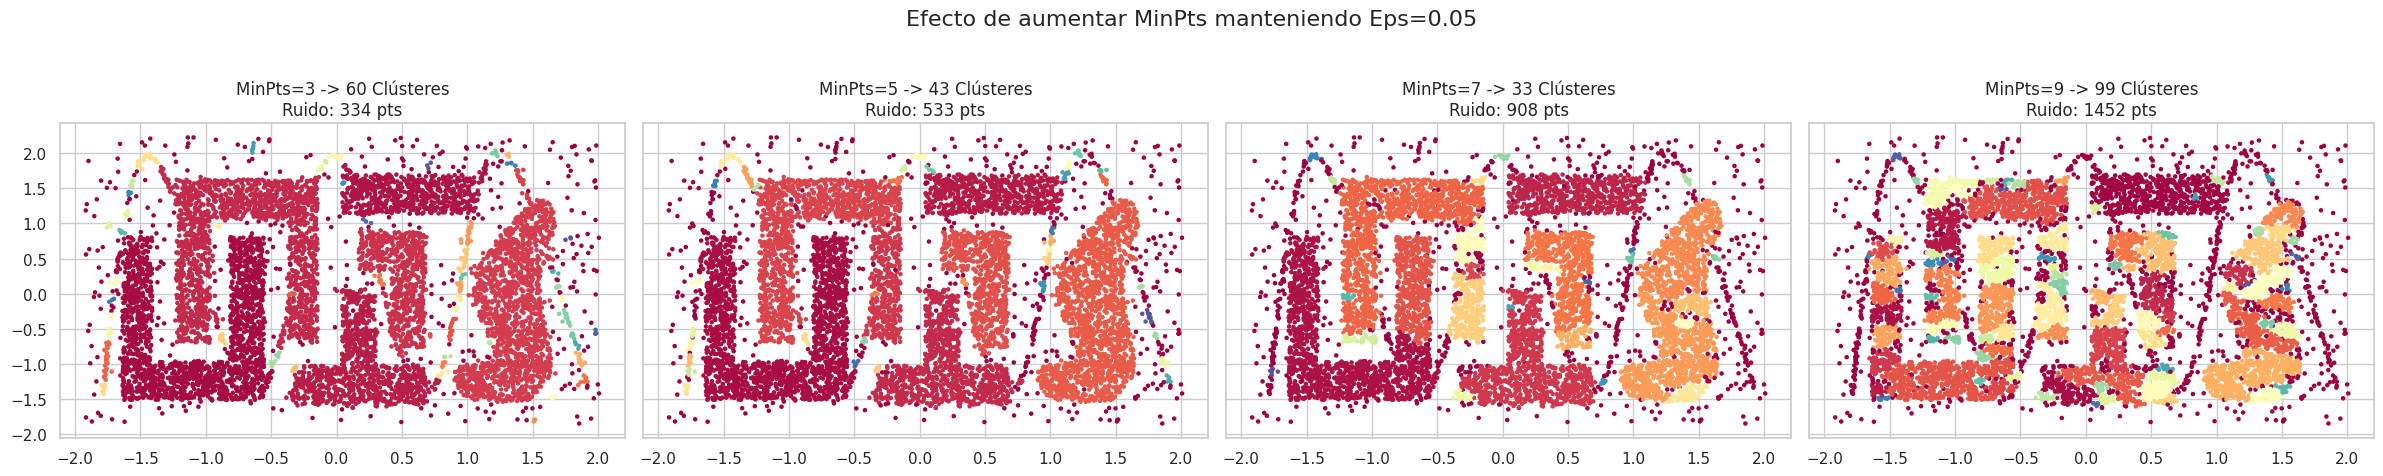

In [ ]:
#5.Variación de MinPts

min_samples_range = [3, 5, 7, 9]
fig, axes = plt.subplots(1, 4, figsize=(24, 5), sharey=True)

for i, min_pts in enumerate(min_samples_range):
    # Al cambiar MinPts, la gráfica k-distancia cambia, por lo que eps óptimo podría variar.
    # Sin embargo, para comparar el efecto de densidad, mantenemos eps constante para ver cómo aumenta el ruido.
    db_sens = DBSCAN(eps=eps_visual, min_samples=min_pts)
    labels_sens = db_sens.fit_predict(X_scaled)

    n_c = len(set(labels_sens)) - (1 if -1 in labels_sens else 0)
    n_n = list(labels_sens).count(-1)

    axes[i].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_sens, cmap='Spectral', s=5)
    axes[i].set_title(f'MinPts={min_pts} -> {n_c} Clústeres\nRuido: {n_n} pts')

plt.suptitle(f'Efecto de aumentar MinPts manteniendo Eps={eps_visual}', fontsize=16 )
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Deja un espacio arriba para el suptitle
plt.show()

El parámetro min_samples actúa efectivamente como un filtro de suavizado.
Bajos Valores ($MinPts \approx 3-5$): El algoritmo es muy permisivo. Pequeñas agrupaciones locales se consideran clústeres. Esto es útil para capturar detalles finos pero susceptible a fusionar clústeres distintos a través de ruido.
Altos Valores ($MinPts \geq 10$): es mejor para suprimir el ruido aleatorio.

Relación con la Gráfica de Codo: Es crucial notar que si cambiamos min_samples, conceptualmente deberíamos recalcular la gráfica de codo usando el nuevo $k = MinPts - 1$. Al aumentar $k$, la curva de distancias se desplaza hacia arriba (la distancia al 20º vecino es siempre mayor que al 4). Por tanto, aumentar min_samples generalmente requiere aumentar $\varepsilon$ para mantener la coherencia estructural, aunque esto aumenta el riesgo de fusiones indeseadas.

¿Es posible encontrar clústeres perfectos en Chameleon con DBSCAN?
No con el algoritmo DBSCAN estándar.
Dado que los clústeres tienen densidades intrínsecas diferentes, no existe un único valor de densidad ($\varepsilon$ para un $MinPts$ dado) que pueda:
Conectar todos los puntos del clúster disperso.
Separar simultáneamente los dos clústeres densos que están muy próximos entre sí.
Con DBSCAN estándar, hay que elegir entre "sobre-segmentar" (dividir clústeres reales) o "sub-segmentar" (fusionar clústeres distintos).
